In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [27]:
def norm(x,p):
    if p=='inf':
        return np.max(np.abs(x))
    else:
        s = np.sum(np.abs(x)**p)
        return s**(1/p)

In [53]:
nd = 5
dvec = 2**np.linspace(2,nd,nd-1,dtype=np.int64)
dvec

array([ 4,  8, 16, 32], dtype=int64)

In [65]:
iter1 = 50
iter2 = 50
p = 1.01
q = p/(p-1)

nd = 8
dvec = 2**np.linspace(1,nd,nd-1,dtype=np.int64)
lend = nd-1

vals = np.zeros(lend)
for k in range(lend):

    d = dvec[k]

    curr = 0

    for i in range(iter1):
        ## define hyperplane
        v = np.random.normal(0,1,size=d)
        v = v/norm(v,2)
        vq = norm(v,q)

        for j in range(iter2):
            x = np.random.normal(0,1,size=d)

            # compute orthogonal projection
            y = np.dot(x,v)*v

            # measure Lp distance
            fake = norm(y,p)

            # measure true distance
            true = np.abs(np.dot(x,v))/vq

            if fake/true > curr:
                curr = fake/true
    vals[k] = curr

            

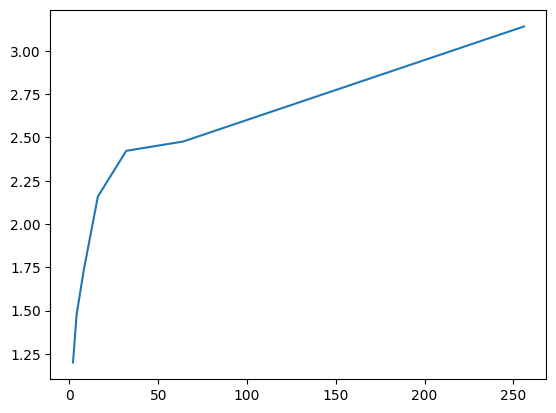

In [66]:
plt.plot(dvec,vals)

In [64]:
def compute_matrix_one_norm(A):
    M = 0
    for i in range(A.shape[1]):
        M = max(M, np.sum(np.abs(A[:,i])))
    return M

In [69]:
d = 100
k = 50
itera = 5000
best = 0

best_list = []
for _ in range(itera):

    A = np.random.normal(size=(d,k))
    Ainv = np.linalg.inv(np.dot(A.T,A))
    Afull = np.dot(A,np.dot(Ainv,A.T))

    # x = np.ones(d)
    # best = max(best, norm(np.dot(Afull,x),'inf'))
    best = max(best, compute_matrix_one_norm(Afull))
    best_list.append(best)

print(best)

4.8909330589077165


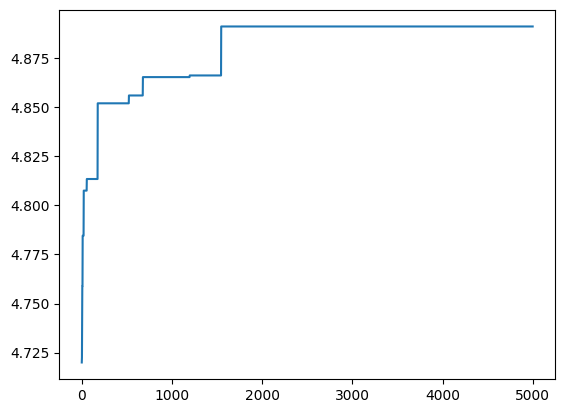

In [70]:
plt.plot(best_list)

In [13]:
import numpy as np

def random_orthogonal_basis(k, attack=False):
    """
    Generates a random orthogonal basis for R^k.

    Parameters:
    k (int): Dimension of the space.

    Returns:
    np.ndarray: A k x k orthogonal matrix whose columns form an orthogonal basis.
    """
    # Generate a random k x k matrix with entries from a standard normal distribution
    A = np.random.randn(k, k)
    if attack:
        # correct A to start with the cursed vector
        A[:,0] = -np.ones(k)
        A[0,0] = k**(1/2)
        A = A.T
    # Perform QR decomposition on A
    Q, R = np.linalg.qr(A)
    return Q

def gram_schmidt(A):
    # Perform QR decomposition on A
    Q, R = np.linalg.qr(A)
    return Q

# Example usage:
k = 100  # Dimension of the space
basis = random_orthogonal_basis(k)
print(f"Random orthogonal basis for R^{k}:")

Random orthogonal basis for R^100:


In [2]:
def inf(matrix):
    """
    Computes the infinity norm of a matrix.

    Parameters:
    matrix (array-like): A 2D list or NumPy array representing the matrix.

    Returns:
    float: The infinity norm of the matrix.
    """
    # Ensure the input is a NumPy array
    matrix = np.array(matrix)
    
    # Compute the infinity norm
    
    infinity_norm = np.sort(np.sum(np.abs(matrix), axis=1))[int(k-1)] #np.max(np.sum(np.abs(matrix), axis=1))
    return infinity_norm

In [15]:
def get_fourier(k):
    mat = np.zeros((k,k))
    x = np.pi*np.arange(k)/k
    for i in range(k):
        mat[:,i] = np.cos(i*x)/(k**0.5)
    return mat

def get_poly(k):
    mat = np.zeros((k,k))
    x = np.pi*np.arange(k)/k
    for i in range(k):
        mat[:,i] = x**i/(k**0.5)
    return mat


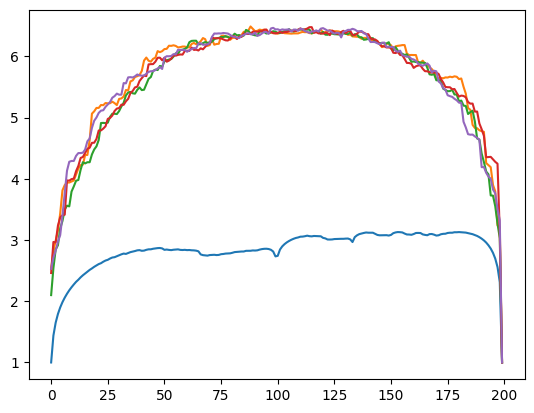

In [14]:
k = 200
N = 5
x = np.arange(k)
basis = gram_schmidt(get_fourier(k))
for _ in range(N):    
    mat = np.zeros((k,k))
    li = np.zeros(k)
    for d in range(k):
        mat += np.dot(basis[:,d:d+1], basis[:,d:d+1].T)
        li[d] = inf(mat)
    basis = random_orthogonal_basis(k)
    plt.plot(x, li)

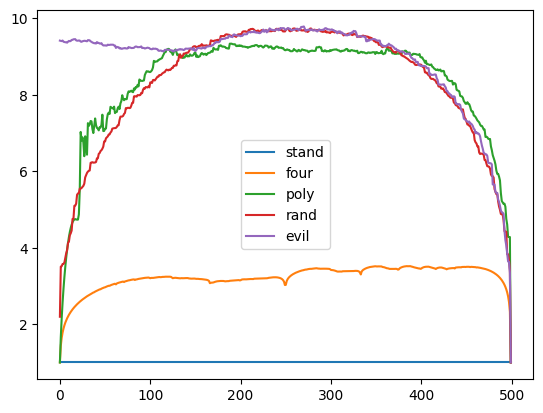

In [18]:
k = 500
x = np.arange(k)
basis_stand = np.identity(k)
basis_four = gram_schmidt(get_fourier(k))
basis_poly = gram_schmidt(get_poly(k))
basis_rand = random_orthogonal_basis(k)
basis_evil = random_orthogonal_basis(k, attack=True)

basis_list = [basis_stand, basis_four, basis_poly, basis_rand, basis_evil]
labels = ['stand', 'four', 'poly', 'rand', 'evil']

for i in range(len(basis_list)):   
    basis = basis_list[i] 
    mat = np.zeros((k,k))
    li = np.zeros(k)
    for d in range(k):
        mat += np.dot(basis[:,d:d+1], basis[:,d:d+1].T)
        li[d] = inf(mat)
    plt.plot(x, li, label = labels[i])


plt.legend()
plt.show()